In [126]:
import pandas

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import numpy as np

# Load, format, clean data

In [127]:
# downloaded data from:
# https://datamarket.com/data/set/22ml/uk-deaths-from-bronchitis-emphysema-and-asthma#!ds=22ml&display=line
ts = pandas.read_csv(
    'uk-deaths-from-bronchitis-emphys.csv', 
    squeeze=True, # results in a pandas Series
    skipfooter=2, 
    index_col=0,
    engine='python',
    parse_dates=True
)

In [128]:
ts

Month
1974-01-01    3035
1974-02-01    2552
1974-03-01    2704
1974-04-01    2554
1974-05-01    2014
1974-06-01    1655
1974-07-01    1721
1974-08-01    1524
1974-09-01    1596
1974-10-01    2074
1974-11-01    2199
1974-12-01    2512
1975-01-01    2933
1975-02-01    2889
1975-03-01    2938
1975-04-01    2497
1975-05-01    1870
1975-06-01    1726
1975-07-01    1607
1975-08-01    1545
1975-09-01    1396
1975-10-01    1787
1975-11-01    2076
1975-12-01    2837
1976-01-01    2787
1976-02-01    3891
1976-03-01    3179
1976-04-01    2011
1976-05-01    1636
1976-06-01    1580
              ... 
1977-07-01    1498
1977-08-01    1361
1977-09-01    1346
1977-10-01    1564
1977-11-01    1640
1977-12-01    2293
1978-01-01    2815
1978-02-01    3137
1978-03-01    2679
1978-04-01    1969
1978-05-01    1870
1978-06-01    1633
1978-07-01    1529
1978-08-01    1366
1978-09-01    1357
1978-10-01    1570
1978-11-01    1535
1978-12-01    2491
1979-01-01    3084
1979-02-01    2605
1979-03-01    2573
1979-0

# Exploration

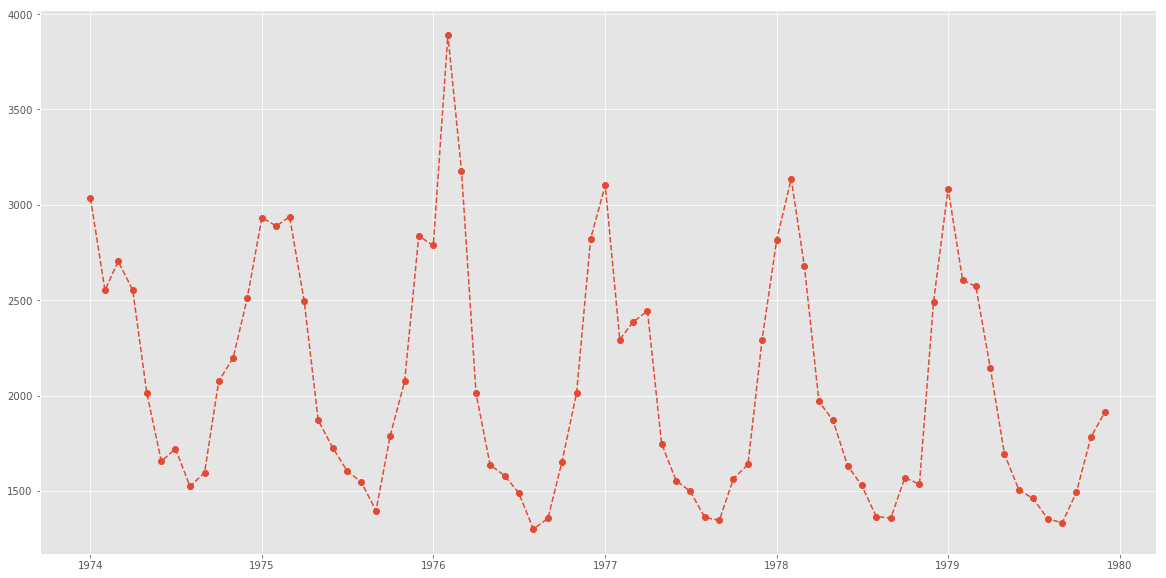

In [129]:
# this time series looks to have some yearly seasonality component to it
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(ts.index, ts, linestyle='--')

### Is it a stationary time series?

In [130]:
def stationary_test(ts):
    # guessing this is period 12
    period = 12
    
    # calculate rolling mean
    roll_mean = ts.rolling(window=period,center=False).mean()
    
    # calculate rolling standard deviation
    roll_std = ts.rolling(window=period,center=False).std()
    
    # let's plot all three time series to visually check if stationary
    plt.plot(ts, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Time Series with Window={}'.format(period))
    plt.show()
    
    # Augmented Dickey-Fuller unit root test is another way to test a TS to see if it is stationary
    # see: http://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
    try:
        dickeyfuller = adfuller(ts, autolag='t-stat', regression='ctt')

        # Results
        labels = ['Test Statistic','p-value','Number of Lags Used','Number of Observations Used']
        for key, value in zip(labels, dickeyfuller[0:4]):
            print("%35s : %0.6f" % (key, value))
        for key, value in dickeyfuller[4].items():
            print("%35s : %0.2f" % ("Critical Value({0})".format(key), value))
    except Exception as e:
        print("ADF Exception message: {}".format(e))

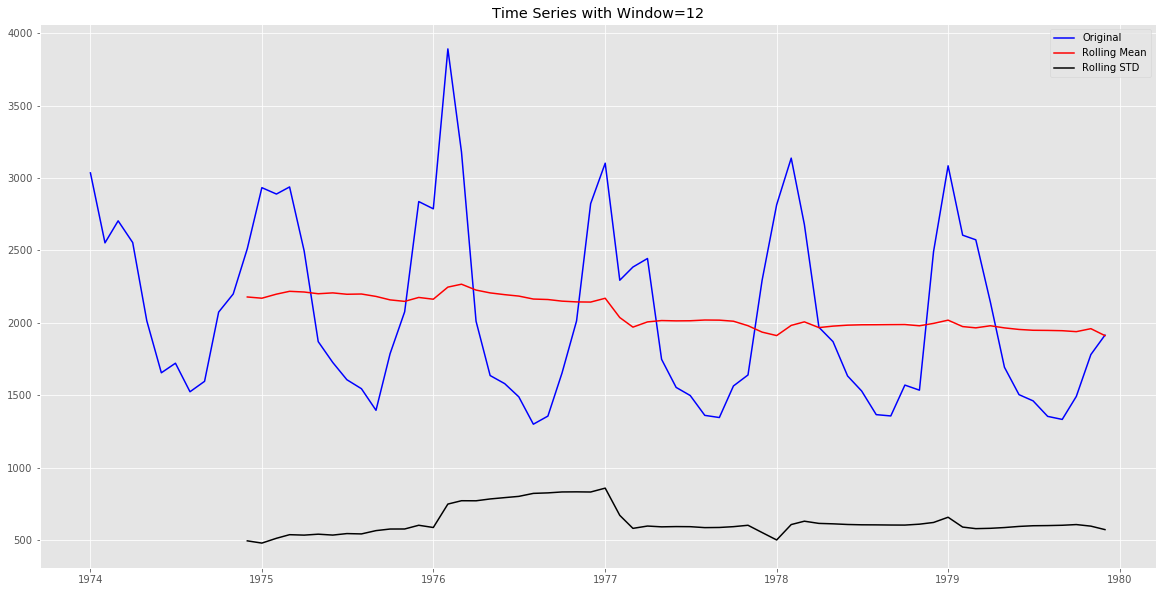

                     Test Statistic : -2.245941
                            p-value : 0.707359
                Number of Lags Used : 12.000000
        Number of Observations Used : 59.000000
                 Critical Value(1%) : -4.58
                 Critical Value(5%) : -3.94
                Critical Value(10%) : -3.62


In [131]:
stationary_test(ts)

### Differencing

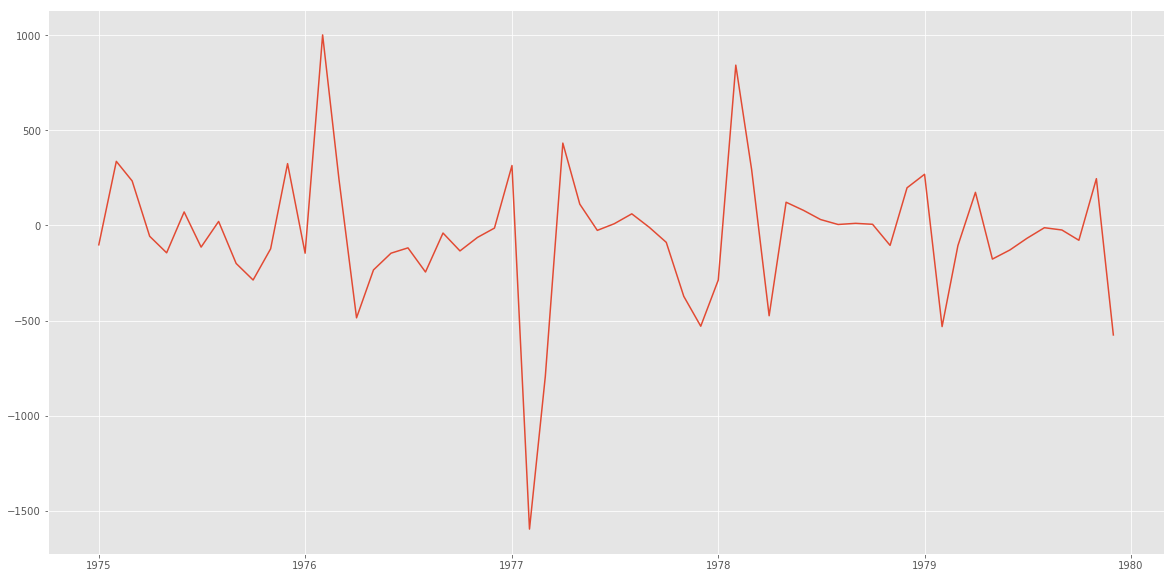

In [132]:
# try differencing to eliminate seasonality
ts_diff = ts - ts.shift(12) # not sure what arg to put here, get error with ADF anyways
plt.plot(ts_diff)

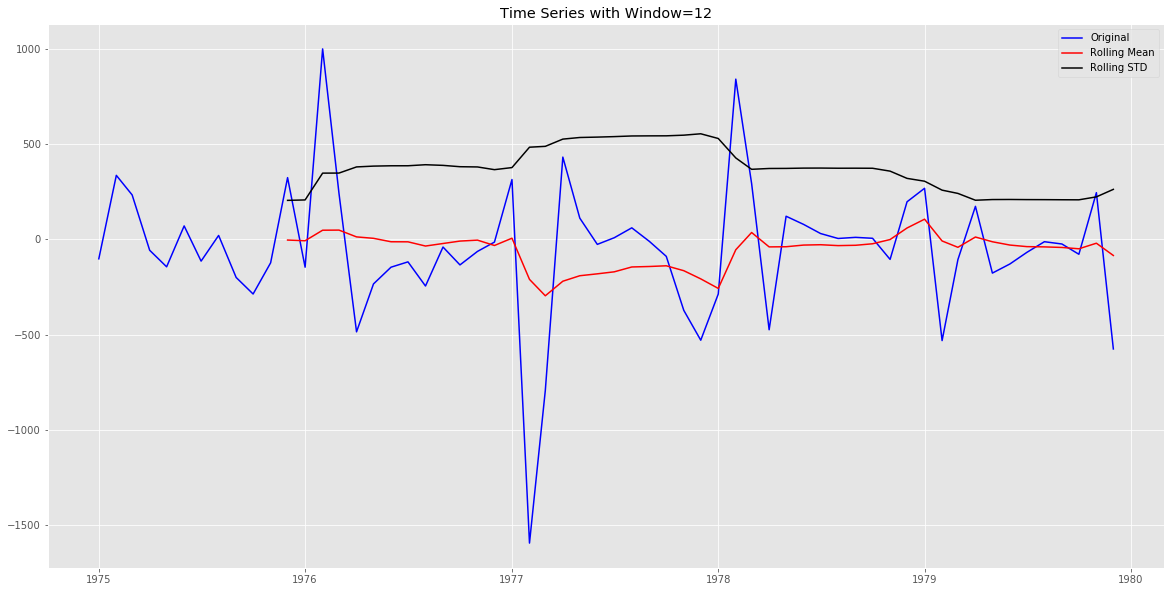

ADF Exception message: SVD did not converge


In [133]:
stationary_test(ts_diff)

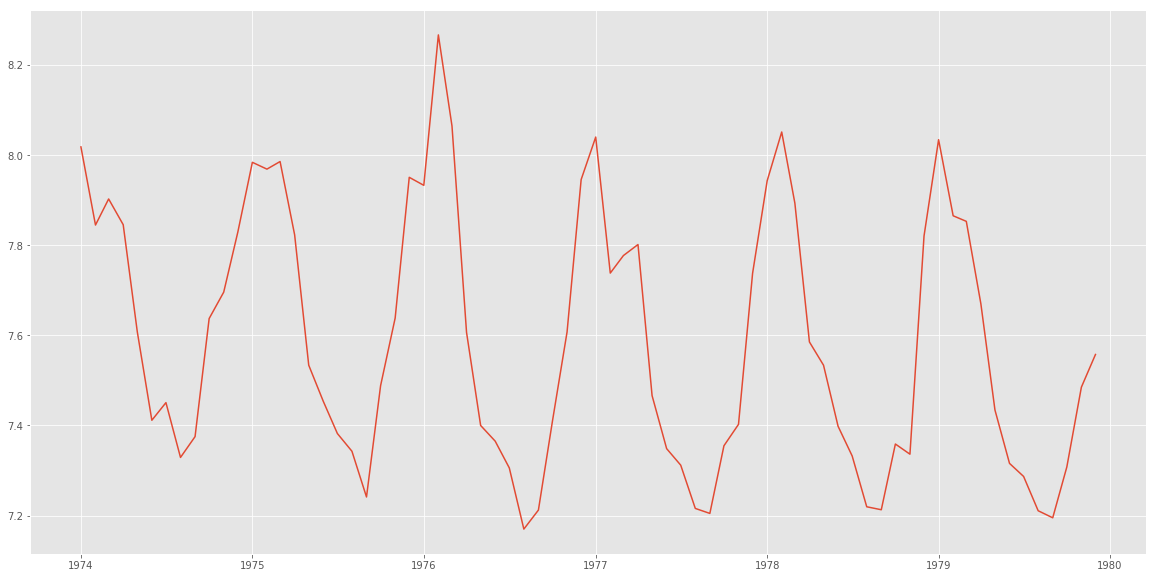

In [134]:
# try log
ts_log = np.log(ts)
plt.plot(ts_log)

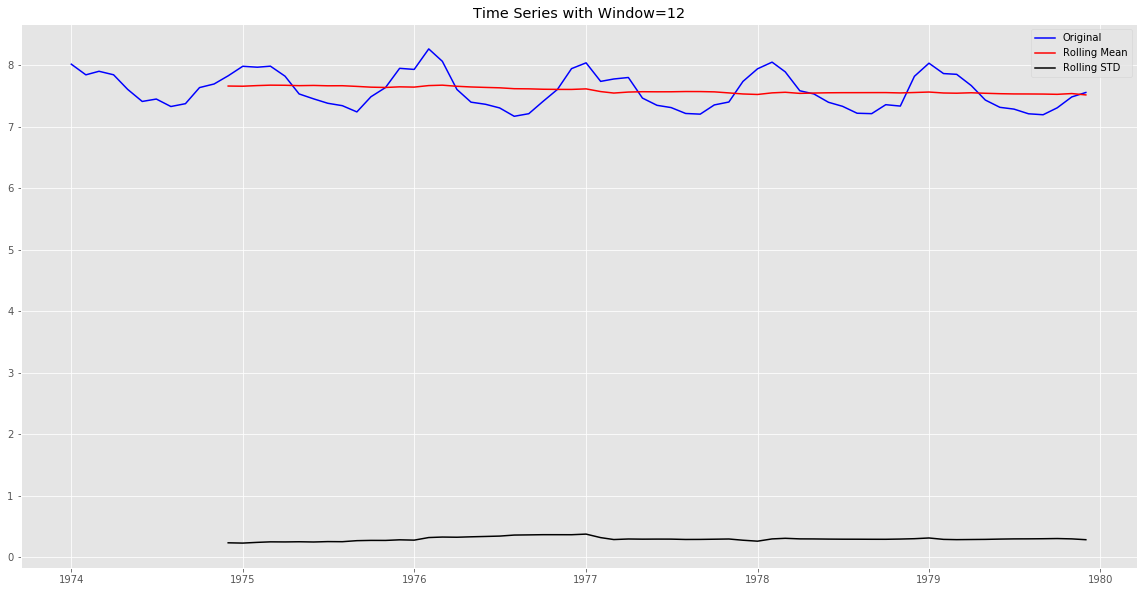

                     Test Statistic : -7.582749
                            p-value : 0.000000
                Number of Lags Used : 7.000000
        Number of Observations Used : 64.000000
                 Critical Value(1%) : -4.56
                 Critical Value(5%) : -3.93
                Critical Value(10%) : -3.61


In [135]:
stationary_test(ts_log)

### Decomposition

In [136]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

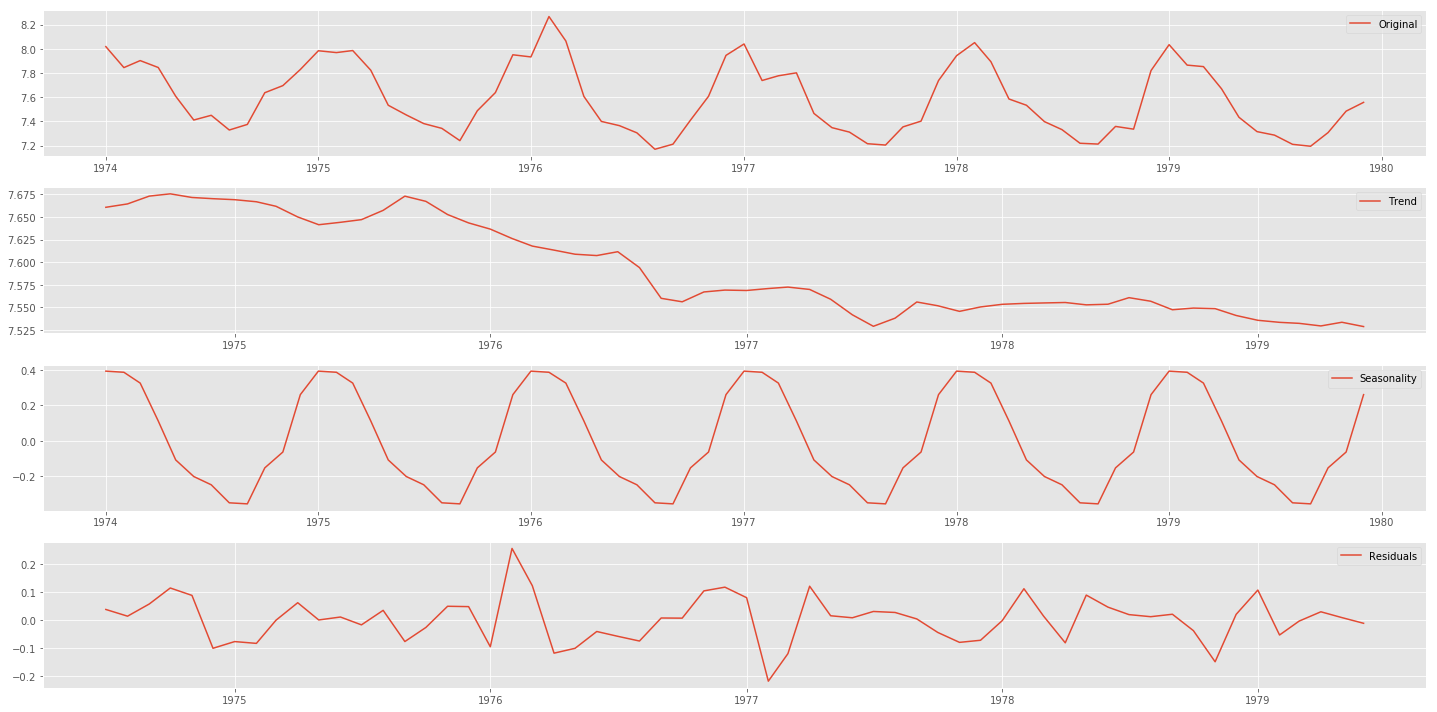

In [137]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

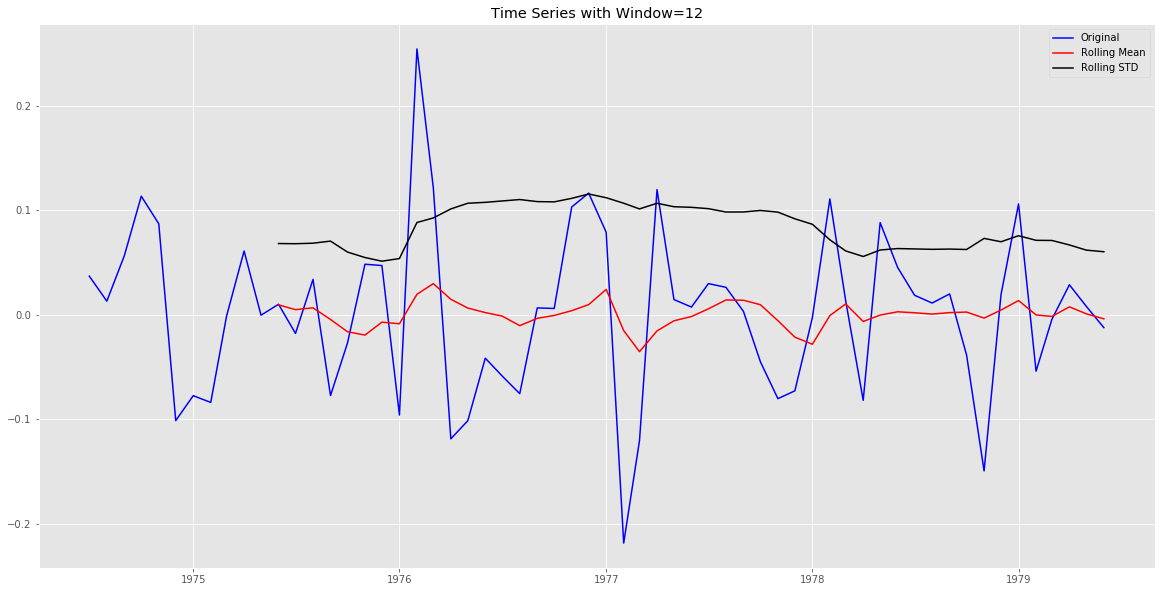

                     Test Statistic : -4.003294
                            p-value : 0.031211
                Number of Lags Used : 11.000000
        Number of Observations Used : 48.000000
                 Critical Value(1%) : -4.63
                 Critical Value(5%) : -3.96
                Critical Value(10%) : -3.63


In [138]:
ts_log_residual = residual
ts_log_residual.dropna(inplace=True)
stationary_test(ts_log_residual)